In [3]:
! pip install -r requirements.txt -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 MB 8.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"

In [5]:
#df = pd.read_csv("/content/claim_dataset_transformed.csv")
df_original = pd.read_csv("/content/Claims Dataset.csv", sep=";")

In [6]:
df_original.set_index("policy_id", inplace=True)

In [7]:
target_col = "claim_status"

feature_cols = [
 "subscription_length",
 "vehicle_age",
 "customer_age",
 'region_density',
 "region_code"]

In [8]:
X = df_original[feature_cols]      # index = policyid
y = df_original[target_col]

No se realiza dicisión en conjunto de prueba y test debidio a que se usa validación curzada

# Entrenamiento de modelos y comparación de métricas

In [9]:
categorical_features = ["region_code"]
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)

modelos = {

    "brf": BalancedRandomForestClassifier(
        n_estimators=200,
        n_jobs=-1,
        sampling_strategy="all",
        replacement=True,
        random_state=42,
    ),
    "eec": EasyEnsembleClassifier(
        random_state=42,
        n_jobs=-1,

    ),
    "gb": GradientBoostingClassifier(
        random_state=42,



    )
}


pipelines = {
    nombre: Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", modelo),
        ]
    )
    for nombre, modelo in modelos.items()
}



cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)


scoring = {
    "roc_auc": "roc_auc",
    "ap": "average_precision",
    "f1": "f1",
    "recall": "recall",

}

resultados = []

for nombre, pipe in tqdm(pipelines.items()):
    cv_res = cross_validate(
        estimator=pipe,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )

    fila = {"modelo": nombre}
    for metrica in scoring.keys():
        scores = cv_res[f"test_{metrica}"]
        fila[f"{metrica}_mean"] = scores.mean()
        fila[f"{metrica}_std"] = scores.std()
    resultados.append(fila)

# 7. Tabla consolidada de resultados
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="ap_mean", ascending=False)  # ordena por AUC-PR medio
    .reset_index(drop=True)
)


100%|██████████| 3/3 [01:25<00:00, 28.49s/it]


In [10]:
df_resultados

,modelo,roc_auc_mean,roc_auc_std,ap_mean,ap_std,f1_mean,f1_std,recall_mean,recall_std
0,gb,0.641549,0.008424,0.096907,0.002043,0.000000,0.000000,0.000000,0.000000
1,eec,0.630648,0.007092,0.092567,0.002435,0.152843,0.002289,0.715327,0.024782
2,brf,0.601839,0.003751,0.083729,0.001381,0.138427,0.003761,0.340711,0.009330


# Calculo de lift

In [11]:
pipe_eec = pipelines["eec"]

proba_oof = cross_val_predict(
    estimator=pipe_eec,
    X=X,
    y=y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1,
)[:, 1]

df_lift = pd.DataFrame(
    {
        "y_true": y,
        "score": proba_oof,
    }
)

In [12]:
# Tasa base de siniestralidad
base_rate = df_lift["y_true"].mean()

# Ordenar por score descendente
df_lift = df_lift.sort_values("score", ascending=False).reset_index(drop=True)

# Crear deciles (1 = top 10% mayor riesgo, 10 = menor)
df_lift["decile"] = pd.qcut(
    df_lift.index + 1,
    q=10,
    labels=False
) + 1

# Agregación por decil
agg = (
    df_lift
    .groupby("decile")
    .agg(
        n=("y_true", "size"),
        events=("y_true", "sum"),
    )
    .reset_index()
)

agg["event_rate"] = agg["events"] / agg["n"]

# Lift puntual por decil
agg["lift_decile"] = agg["event_rate"] / base_rate

# Métricas acumuladas
agg["cum_n"] = agg["n"].cumsum()
agg["cum_events"] = agg["events"].cumsum()
agg["cum_event_rate"] = agg["cum_events"] / agg["cum_n"]

# Lift acumulado
agg["lift_cum"] = agg["cum_event_rate"] / base_rate

# Ordenar por decil (1 = top 10%, 10 = todo el portafolio)
agg = agg.sort_values("decile")

agg

,decile,n,events,event_rate,lift_decile,cum_n,cum_events,cum_event_rate,lift_cum
0,1,5860,607,0.103584,1.619309,5860,607,0.103584,1.619309
1,2,5859,557,0.095067,1.486177,11719,1164,0.099326,1.552749
2,3,5859,514,0.087728,1.371445,17578,1678,0.095460,1.492318
3,4,5859,485,0.082779,1.294068,23437,2163,0.092290,1.442757
4,5,5859,378,0.064516,1.008572,29296,2541,0.086735,1.355923
5,6,5859,389,0.066394,1.037922,35155,2930,0.083345,1.302925
6,7,5859,313,0.053422,0.835141,41014,3243,0.079071,1.236100
7,8,5859,222,0.037890,0.592336,46873,3465,0.073923,1.155631
8,9,5859,159,0.027138,0.424241,52732,3624,0.068725,1.074367
9,10,5860,124,0.021160,0.330798,58592,3748,0.063968,1.000000


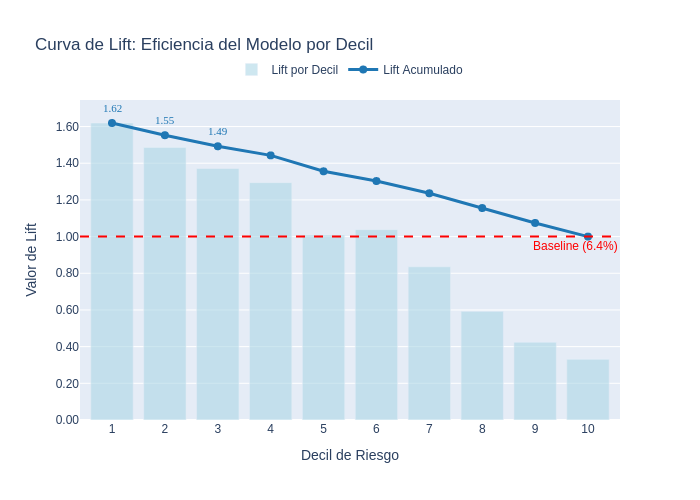

In [13]:
fig = go.Figure()


fig.add_trace(go.Bar(
    x=agg['decile'],
    y=agg['lift_decile'],
    name='Lift por Decil',
    marker_color='rgba(173, 216, 230, 0.6)',
    hovertemplate='Decil: %{x}<br>Lift Decil: %{y:.2f}<extra></extra>'
))


fig.add_trace(go.Scatter(
    x=agg['decile'],
    y=agg['lift_cum'],
    name='Lift Acumulado',
    mode='lines+markers',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8, color='#1f77b4'),
    hovertemplate='Decil: %{x}<br>Lift Acumulado: %{y:.2f}<extra></extra>'
))


fig.add_hline(
    y=1.0,
    line_dash="dash",
    line_color="red",
    annotation_text="Baseline (6.4%)",
    annotation_position="bottom right",
    annotation_font_color="red"
)


for i in range(3):
    fig.add_annotation(
        x=agg.loc[i, 'decile'],
        y=agg.loc[i, 'lift_cum'],
        text=f"{agg.loc[i, 'lift_cum']:.2f}",
        showarrow=False,
        yshift=15,
        font=dict(size=11, color='#1f77b4', family='Arial Black')
    )


fig.update_layout(
    title={
        "text": "Curva de Lift: Eficiencia del Modelo por Decil"
    },
    xaxis_title="Decil de Riesgo",
    yaxis_title="Valor de Lift",
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.05,
        xanchor='center',
        x=0.5
    ),
    hovermode='x unified'
)

# Update axes
fig.update_xaxes(
    tickmode='linear',
    tick0=1,
    dtick=1
)

fig.update_yaxes(
    tickformat='.2f'
)